# yt particle indexing, selector objects applied to dask arrays


This notebook explores a couple aspects of returning dask arrays from yt including impliciations for user-defined distributed workflows and possible improvements to yt's index and io frontend classes. 


It uses the https://github.com/chrishavlin/yt/tree/dask_init_particle branch with a few small modifications. First, in `BaseIOHandler._read_particle_selection`, it does not call compute on the dask arrays in the field dictionary, so that delayed arrays are returned. Second, the following code in `data_selection_objects.YTSelectionContainer`:

```python
        for f, v in read_particles.items():
            self.field_data[f] = self.ds.arr(v, units=finfos[f].units)
            self.field_data[f].convert_to_units(finfos[f].output_units)            
```    

is replaced with 

```python
        from unyt import dask_array

        for f, v in read_particles.items():
            da_f = dask_array.unyt_from_dask(v, units=finfos[f].units, registry=self.ds.unit_registry)
            self.field_data[f] = da_f.to(finfos[f].output_units)
```      

this will result in returing `unyt_dask` arrays! 

### returning dask arrays

Ok, let's first take a look at what the above branch returns on a normal read:

In [2]:
import yt 

ds = yt.load_sample("snapshot_033")
ad = ds.all_data()
field = ("PartType0","Density")
data = ad[field]
data

yt : [INFO     ] 2021-06-10 08:58:23,420 Files located at /home/chris/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.
yt : [INFO     ] 2021-06-10 08:58:23,420 Default to loading snap_033.0.hdf5 for snapshot_033 dataset
yt : [INFO     ] 2021-06-10 08:58:23,534 Parameters: current_time              = 4.343952725460923e+17 s
yt : [INFO     ] 2021-06-10 08:58:23,534 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-06-10 08:58:23,535 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-06-10 08:58:23,536 Parameters: domain_right_edge         = [25. 25. 25.]
yt : [INFO     ] 2021-06-10 08:58:23,537 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-06-10 08:58:23,537 Parameters: current_redshift          = -4.811891664902035e-05
yt : [INFO     ] 2021-06-10 08:58:23,537 Parameters: omega_lambda              = 0.762
yt : [INFO     ] 2021-06-10 08:58:23,538 Parameters: omega_matter              = 0.238
yt : [

unyt_dask_array<mul, shape=(1941226,), dtype=float64, chunksize=(262144,), chunktype=numpy.ndarray, units=code_mass/code_length**3>

what we get back is a delayed dask-unyt array (the unyt-ness isn't so important for this discussion...). The dask-chunks relate directly to how yt indexes particle data. The yt dataset `index` class uses spatial bitmap coordinates to divide a dataset domain and map domain regions to where data is stored (e.g., on-disk files), allowing yt to quickly identify which files need to be read for a given spatial selection and avoid unnecessary reading. We can check out how yt has split up our dataset with:




In [3]:
ds.index.data_files

In [4]:
len(ds.index.data_files)

12

and we see that we have 12 `ParticleFile` objects in our `data_files` list. Each file object here represents both an on-disk file and a file-index range with the file (a single on-disk file may be split up into multiple file objects depending on `ds.index.chunksize`). 

Returning to the dask array, we see we have 9 dask-chunks. Each of these chunks corresponds directly to one of these file objects. It turns out we only have 9 despite having used the `all_data` selector because yt uses a single indexing across particle types and the particle type we selected for output here (`PartType0`) happens to not have any particles in 3 of the 12 files. 

In any case, when we call 

In [6]:
data_in_mem = data.compute()

dask goes and applies the selector to each of the dask-chunks (which are equivalent to `PartileFile` objects) separately and then gathers each chunk to our in-memory unyt array:

In [7]:
data_in_mem

unyt_array([ 6577205. , 15850306. ,  6765328.5, ...,  4304681.5,
             5155429.5,  7586393.5], dtype=float32, units='code_mass/code_length**3')

### custom distributed yt workflows with dask arrays

One of the neat things about returning dask arrays is that it is **very** easy to construct distributed workflows for which yt does not have built in parallel support. 

For example, let's say you wanted to find the spatial centroid of all the particle positions meeting some criteria (full disclosure: I am no astrophysicist, this example may or may not have any physical relevance). 

We can instantiate all our dask arrays for multiple fields with a call to `get_data` and create a mask based on some condition using normal array syntax:

In [10]:
fields = [('PartType4', 'Coordinates'),
          ('PartType4', 'Density'),          
          ('PartType4', 'Hydrogen')]
ad.get_data(fields=fields)

In [22]:
mean_hyd = ad[('PartType4', 'Hydrogen')].mean().compute()
mean_hyd

unyt_quantity(0.70401761, '(dimensionless)')

In [23]:
mean_den = ad[('PartType4', 'Density')].mean().compute()
mean_den

unyt_quantity(11868642.38222822, 'code_mass/code_length**3')

In [26]:
mask = (ad[('PartType4', 'Hydrogen')] > mean_hyd) & (ad[('PartType4', 'Density')] > mean_den )
mask

dask.array<and_, shape=(155926,), dtype=bool, chunksize=(20772,), chunktype=numpy.ndarray>

and extract the particle positions satisfying our conditions:

In [29]:
pos = ad[("PartType4","Coordinates")][mask, :]

unyt_dask_array<mul, shape=(155926, 3), dtype=float64, chunksize=(20772, 3), chunktype=numpy.ndarray, units=code_length>

and then find our average position of these particles with:

In [32]:
pos.mean(axis=0).compute()

unyt_array([11.65921564, 13.02354874, 10.1216519 ], 'code_length')

These operations could be reproduced using yt's `cut` selector object, but it's nice to be able to do these operations on the fly with familiar array syntax! It's also nice because with since we are constructing dask arrays throughout, even computations on derived/masked fields will also be executed in parallel (or series, depending on the dask client).

### array all the things! (but don't)

Given that we're returning these dask arrays, we could in principle always use the yt `all_data()` selector and then do our own spatial selections on the fly. For example let's do a selection equivalent to `yt.sphere()` manually with dask arrays:

In [50]:
import numpy as np 

C = ds.domain_center.value  # converting to plain float array cause of unyt_dask bug... 
R = float(ds.quan(1,'code_length').value)
xyz = ad[('PartType4', 'Coordinates')]
dist = np.sqrt( (xyz[:,0] - C[0])**2 + (xyz[:,1] - C[1])**2 + (xyz[:,2]- C[2])**2 )
sphere_mask = dist <= R

this `sphere_mask` can then be used on any dask array and it'll go and apply it to each dask-chunk separately:

In [51]:
den_sp_manual = ad[("PartType4","Density")] [sphere_mask] 
den_sp_manual

dask.array<getitem, shape=(nan,), dtype=float64, chunksize=(nan,), chunktype=numpy.ndarray>

Let's get it back in memory and check that it matches the normal yt `sphere` selector result:

In [52]:
den_sp_manual_mem = den_sp_manual.compute()

In [53]:
den_sp_manual_mem

array([ 611130.3  ,  122534.305, 1445628.4  , 1740564.5  ,  537264.56 ,
        377391.84 ,  758083.94 ,  372481.9  ,  222926.1  ,  819874.3  ,
        678404.9  ], dtype=float32)

the yt-way:

In [54]:
C = ds.domain_center.value
R = float(ds.quan(1,'code_length').value)
sp = ds.sphere(C, R)
den_sp = sp[("PartType4","Density")].compute()
den_sp

unyt_array([ 611130.3125,  122534.3046875, 1445628.375, 1740564.5  ,
             537264.5625,  377391.84375,  758083.9375,  372481.90625,
             222926.09375,  819874.3125,  678404.875], dtype=float32, units='code_mass/code_length**3')

and a check to make sure we're getting the same results:

In [55]:
np.all(den_sp_manual_mem == den_sp.value)

True

So that's kind of neat! But before we go re-writing all of yt to use array syntax, remember that the yt selector objects have some extra optimization built in. The biggest one is that in the pure dask-array approach, every dask-chunk of `all_data()` will be checked to see if it satisfies the mask. The yt selector, however, will **first** check the spatial index of each file object and discard those that do not intersect our selector. This initial check happens in the `ds.index.regions.identify_file_masks` function. For our sphere selector:

In [56]:
dfi, file_masks, addfi = ds.index.regions.identify_file_masks(
                    sp.selector
                )  
dfi

array([ 0,  2,  4,  6,  8,  9, 11], dtype=uint32)

In [57]:
len(dfi)

7

we see that only 7 of the 12 data file objects need to be checked. For `all_data()`:

In [58]:
dfi, file_masks, addfi = ds.index.regions.identify_file_masks(
                    ad.selector
                )  
dfi

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=uint32)

In [59]:
len(dfi)

12

we'll have to check all 12 `data_files` (remember that our dask-chunks already include a step of discarding those in the 12 with 0 particles of our particle type).


The second important difference is that the selector objects will do a fuzzy-selection depending on a "smoothing length". We could adjust our array slicing mask to account for a smoothing length, but at that point we start to lose some of the simplicity that makes the array slicing fun. 

## using yt's indexing and selector objects to limit dask arrays

It is possible, however, to actually use yt's indexing to cull our dask-chunks **and** to directly apply yt's selector objects to dask arrays. 

So let's write a little function to return a field along with the corresponding particle coordinates and smoothing length from `all_data()`:

In [60]:
def get_all_data(ds, field):
    # returns delayed dask arrays from all_data 
    
    # instantiate the dask arrays that store the field as well as the particle coordinates and hmsl
    # each dask array will have the same number of dask chunks, each dask chunk points to a single yt index.data_files object
    ptype = field[0]    
    coordfield=(ptype, "Coordinates") # needed for final mask
    hmlsfield=(ptype, "smoothing_length") # needed for final mask
    fields = [field, coordfield, hmlsfield]  
    ad=ds.all_data()  # index gets built here!
    ad.get_data(fields=fields) # will instantiate all the dask arrays
    
    # pull out the references
    data = ad[field]
    pos = ad[coordfield]
    hmsl = ad[hmlsfield]
    
    return data, pos, hmsl

In [61]:
field = ("PartType0","Density")
data, pos, hmsl = get_all_data(ds, field)
data

unyt_dask_array<mul, shape=(1941226,), dtype=float64, chunksize=(262144,), chunktype=numpy.ndarray, units=code_mass/code_length**3>

and we see that 9 of our 12 data file objects have particles of this type. We can further cull our chunks **before** doing any array slicing by using the dask array `.blocks` method to slice our dask array by dask-chunk using yt's index file masking!

In [62]:
data.blocks?

Type:        property
String form: <property object at 0x7f5a2cb53a10>
Docstring:  
Slice an array by blocks

This allows blockwise slicing of a Dask array.  You can perform normal
Numpy-style slicing but now rather than slice elements of the array you
slice along blocks so, for example, ``x.blocks[0, ::2]`` produces a new
dask array with every other block in the first row of blocks.

You can index blocks in any way that could index a numpy array of shape
equal to the number of blocks in each dimension, (available as
array.numblocks).  The dimension of the output array will be the same
as the dimension of this array, even if integer indices are passed.
This does not support slicing with ``np.newaxis`` or multiple lists.

Examples
--------
>>> import dask.array as da
>>> x = da.arange(10, chunks=2)
>>> x.blocks[0].compute()
array([0, 1])
>>> x.blocks[:3].compute()
array([0, 1, 2, 3, 4, 5])
>>> x.blocks[::2].compute()
array([0, 1, 4, 5, 8, 9])
>>> x.blocks[[-1, 0]].compute()
array([8, 9,

so if we have our file mask indices for any selector object

In [65]:
C = ds.domain_center.value
R = float(ds.quan(1,'code_length').value)
sp = ds.sphere(C, R)

dfi, file_masks, addfi = ds.index.regions.identify_file_masks(
                    sp.selector
                )  
dfi

array([ 0,  2,  4,  6,  8,  9, 11], dtype=uint32)

we can in principle limit our `all_data()` dask array with `data.blocks[dfi]` to remove the dask-chunks that we know we don't need to check! 

There's a small wrinkle here -- the `dfi` calculation does **not** distinguish particle type, so `dfi` can be in the `range(0,len(ds.index.data_files))`. But our dask array already removed those files without particles of our `PartType0` and so we first need to offset our `dfi` to account for those files subsequently ruled out:

In [66]:
def sanitize_file_mask(ds, dfi, field):
    
    # the initial read of data from all_data() already culls data_file objects with no particles, but 
    # ds.index.regions.identify_file_masks only limits based on bitmap hits. So we need to offset the 
    # ds.index.regions.identify_file_mask output or we will try to access elements out of range. 
    offset = 0
    mapping = {}
    for i in range(len(ds.index.data_files)):
        if ds.index.data_files[i].total_particles[field[0]] > 0:
            mapping[i] = i - offset
        else:
            offset += 1
            
    return np.array([mapping[i] for i in dfi if i in mapping]) # if it's not in mapping, it's a zero


dfi = sanitize_file_mask(ds, dfi, field)
dfi

array([0, 2, 3, 4, 5, 6, 8])

and we see that for our file mask values are now in the range ouf our dask array chunks. Let's write another helper function to capture the steps above and limit all of the arrays we've pulled out:






In [68]:
def limit_by_index(ds, data, pos, hmsl, selector, field):
    # returns dask arrays with dask-chunks culled by the bitmap file masks
    
    # get dask arrays where each dask-chunk refers to a yt index.data_Files object 
       
    
    # get our list of files that are hit by the selector
    dfi, file_masks, addfi = ds.index.regions.identify_file_masks(
                        selector.selector
                    )    
    dfi = sanitize_file_mask(ds, dfi, field) # accounts for the fact that all_data already removes some data_files
    
    # cull the dask chunks to remove data_files not hit by selector
    data = data.blocks[dfi]
    pos  =  pos.blocks[dfi]
    hmsl = hmsl.blocks[dfi]
                     
    return data, pos, hmsl

In [69]:
field = ("PartType0","Density")
data, pos, hmsl = get_all_data(ds, field)
sp = ds.sphere(ds.domain_center, ds.quan(1, 'code_length'))
data, pos, hmsl = limit_by_index(ds, data, pos, hmsl, sp, field)
data

dask.array<blocks, shape=(1712939,), dtype=float64, chunksize=(262144,), chunktype=numpy.ndarray>

and now we're down to only 7 dask-chunks to check! 

So now how do we apply our selector? 

Well what *yt* does, is for each of those files (which get iterated through with yt's `chunk` iterator), yt will build a mask from the selector object:

```python
mask = sp.selector.select_points(pos_x , pos_y, pos_z, hmsl)
```

and return the data field after applying this mask to the raw on-disk arrays. But it turns out we can apply this function **directly** to dask arrays with the `map_blocks` function! Let's do that and then explain:

In [70]:
pos_x = pos[:,0]
pos_y = pos[:,1]
pos_z = pos[:,2]

mask_by_chunk = pos_x.map_blocks(sp.selector.select_points, pos_y, pos_z, hmsl, meta=np.array((), dtype=bool))
mask_by_chunk

dask.array<select_points, shape=(1712939,), dtype=bool, chunksize=(262144,), chunktype=numpy.ndarray>

In the above code block, we are telling dask that we want to call `sp.selector.select_points` for each dask-chunk. Dask assumes the first argument to the function is the originating array itself, in this case `pos_x`, and then addition args to `map_blocks` are passed to the function in order (the final `meta` keyword argument is telling dask what kinda of array to expect, otherwise it would try to call `sp.selector.select_points` with 0 values to try to guess the output type). 

So now to use our mask, we just use our slicing syntax:

In [72]:
sphere_data = data[mask_by_chunk]
sphere_data

dask.array<getitem, shape=(nan,), dtype=float64, chunksize=(nan,), chunktype=numpy.ndarray>

since we don't yet know how many particles will satisfy this mask, we don't yet know our final array size. 

Before executing, let's check out our task graph:

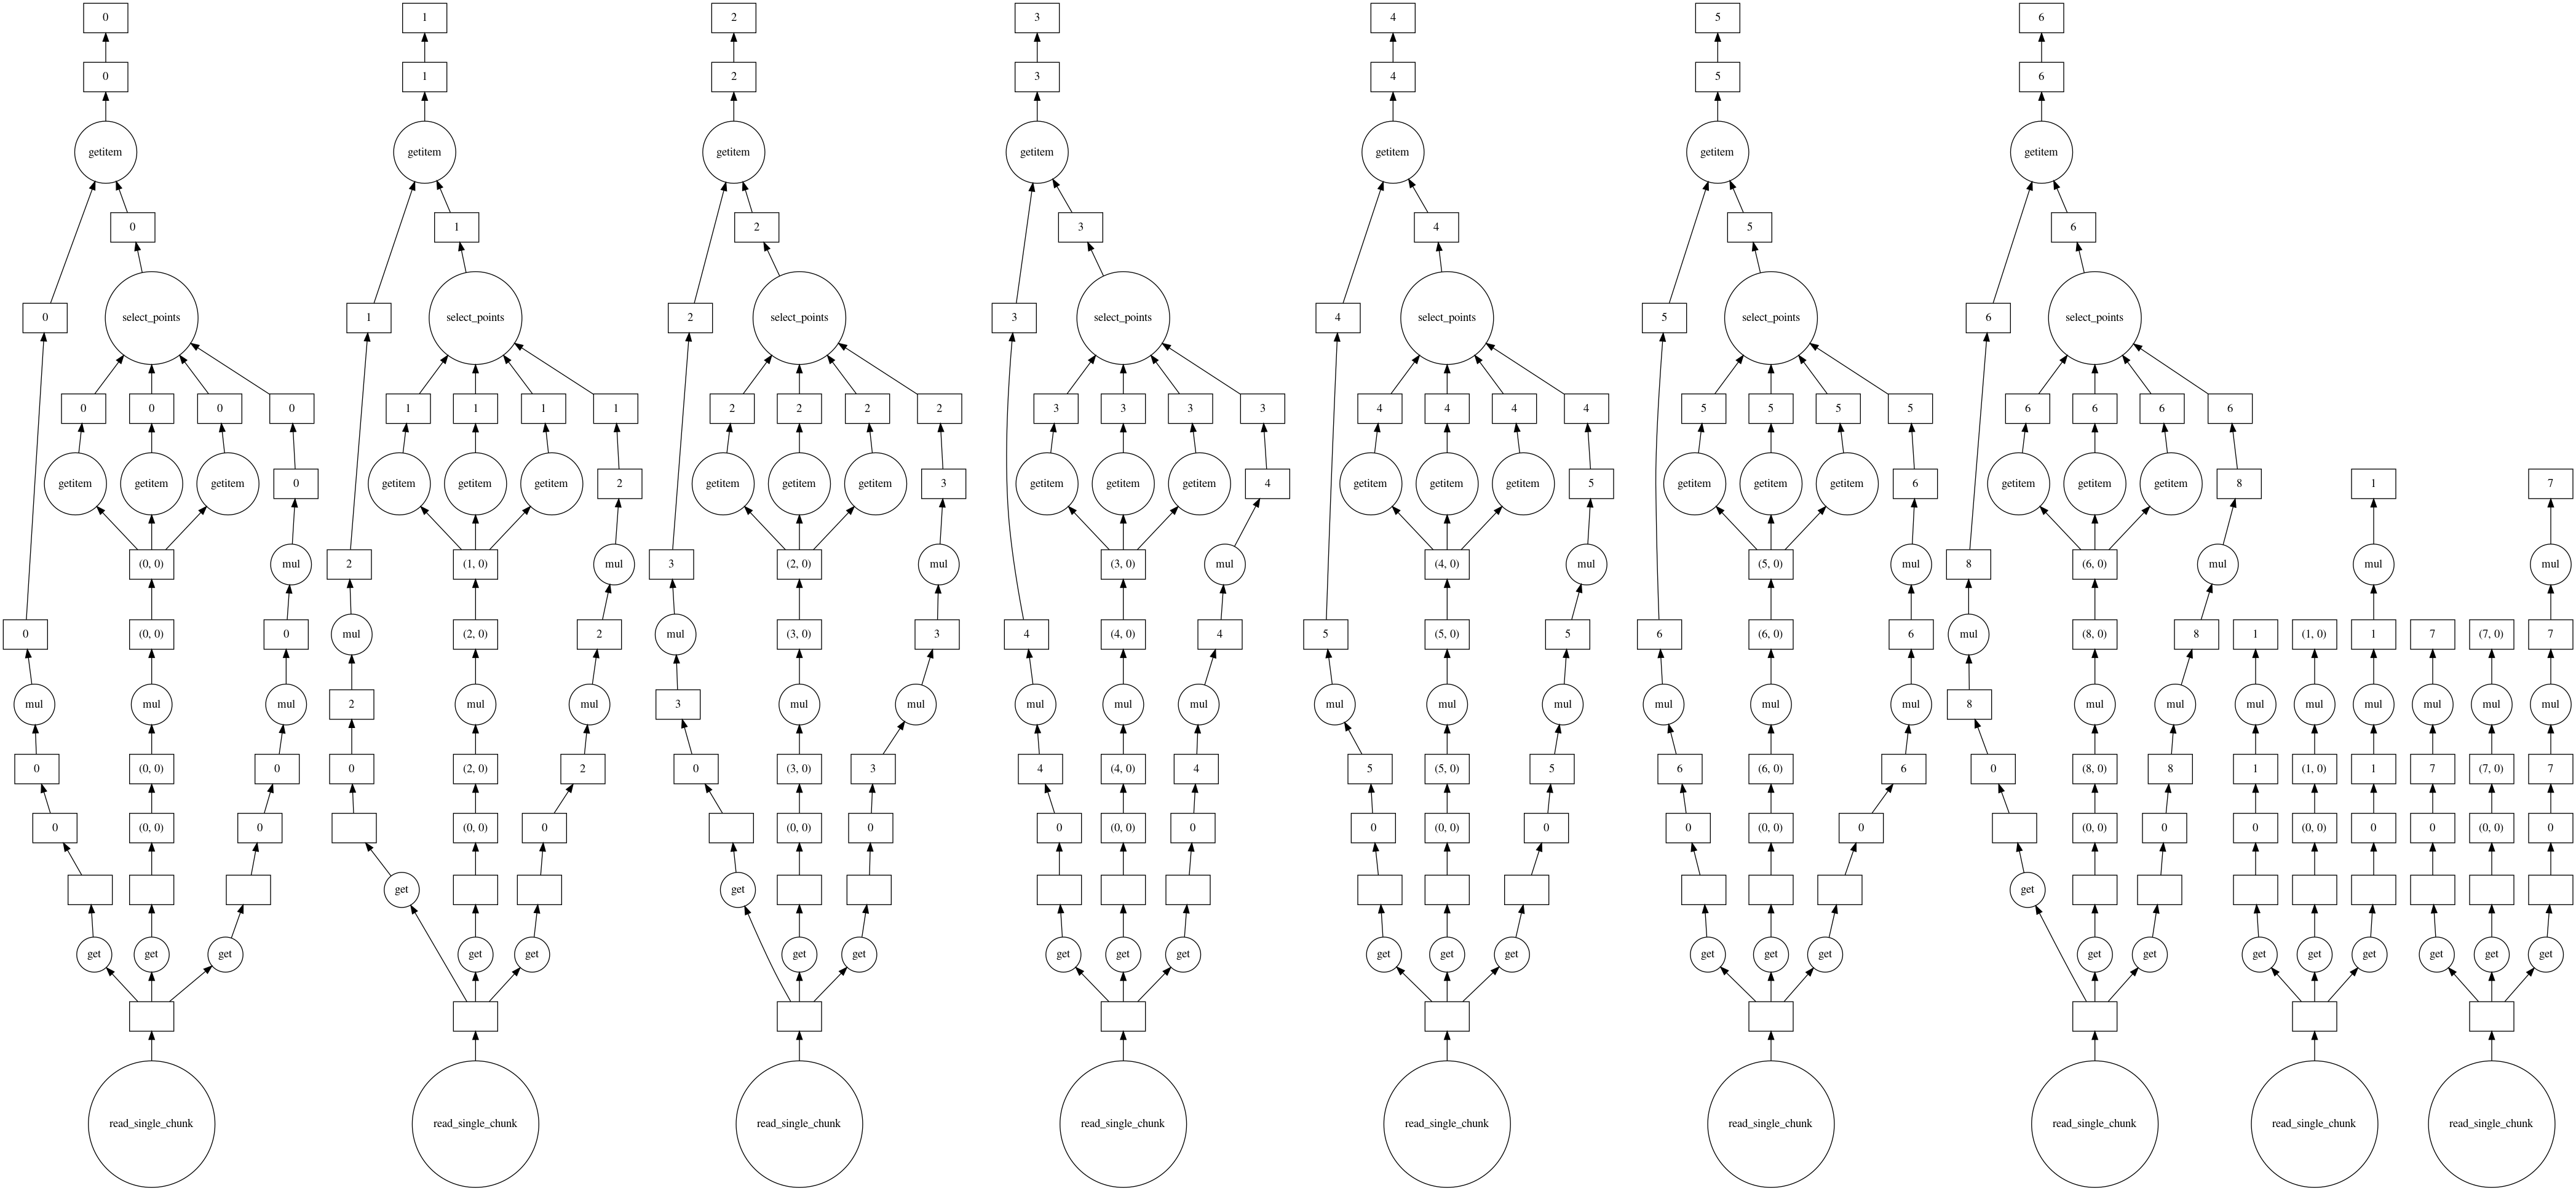

In [73]:
sphere_data.visualize()

This graph clearly illustrates all of the steps that go into our operation, proceeding from bottom to top. The bottom contains 9 separate calls to `read_single_chunk`, corresponding to our 9 file objects of `all_data()` (again, already culled to remove files with no particles of the type we are reading). Most of the steps here are applciations of slicing, and there's a lot going on, but we can see several things that make this a nice graph. Most importantly, each of our file objects is on it's on path. This means no communication between the processes that will handle each dask-chunk which is great for parallel execution. We also see that two of our chunks don't proceed through the whole process -- these are the chunks we're thowing out using yt's file mask indexing as they do not overlap with our sphere selector. 

We can check out a reduced complexity graph to illustrate this more clearly:

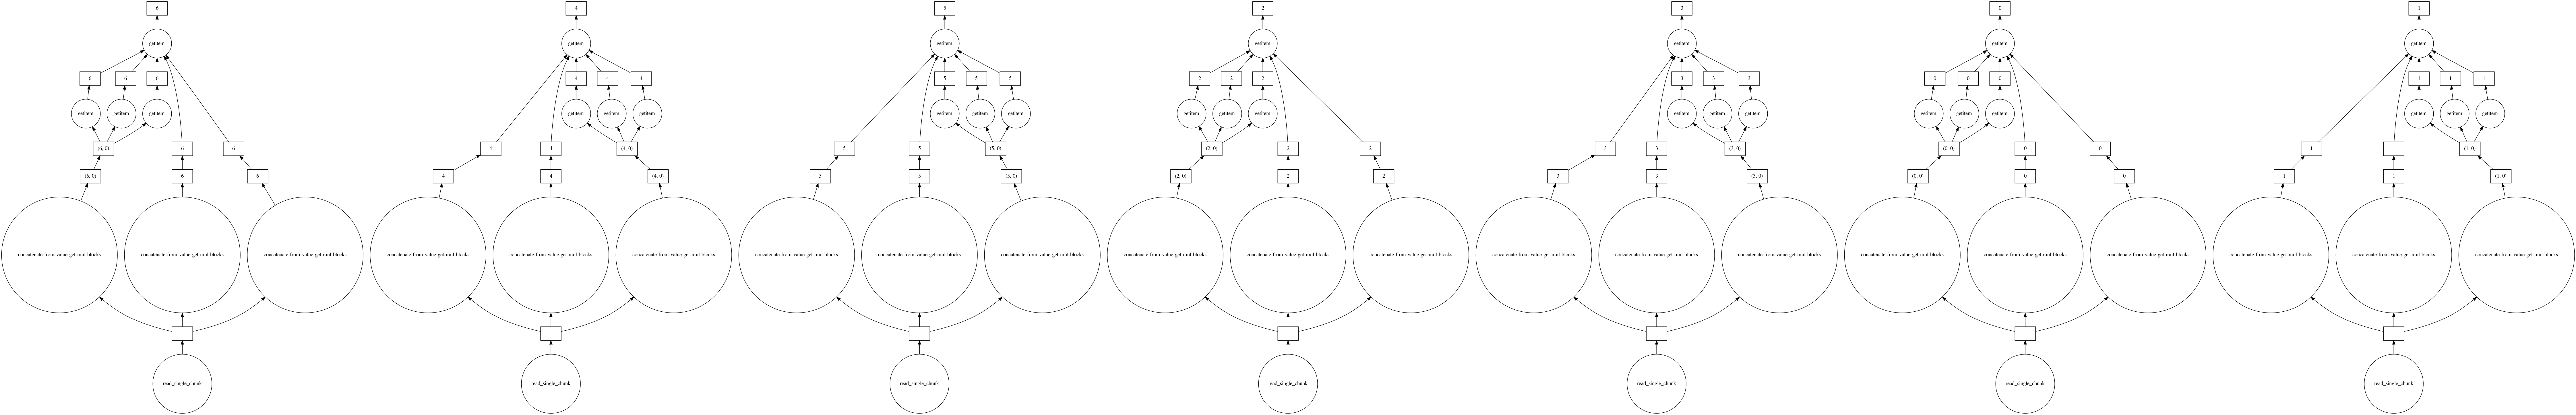

In [74]:
sphere_data.visualize(optimize_graph=True)

so we see only the dask-chunks for which we need to bother applying the mask, and all the sequential slicing is gathered into single steps. 

So when we call 

In [75]:
sphere_data_in_mem = sphere_data.compute()
sphere_data_in_mem

array([30.862764 , 35.818253 , 29.61068  , ...,  3.996618 ,  3.162214 ,
        6.6422577], dtype=float32)

all of the reading and masking for a given chunk is handled by its own process. This is equivalent to how yt operates: it loops over the data file objects and applies the selector mask separately. The only potential performance difference is in the file reads -- I'm not yet sure how dask will handle getting the coordinate, smoothing length and data arrays for each chunk (I suspect that dask will open/close the same file 3 times to get these 3 arrays for one chunk, but I'm not sure). 

Before going into a discussion of why any of this might be useful, let's again verify that we're getting the same result as a standard yt selector:

In [76]:
sp_yt_sel = sp[field].compute().value # this is a unyt-dask array, just get a nd array. 
sp_yt_sel

array([30.862764 , 35.818253 , 29.61068  , ...,  3.996618 ,  3.162214 ,
        6.6422577], dtype=float32)

In [77]:
np.all(sp_yt_sel == sphere_data_in_mem)

True

## some final thoughts

Ok, so that's all pretty neat. Being able to expose the dask arrays certainly opens up the possibility of the average yt-user building their own distributed methods, which is cool. But all this selector business does not really seem simpler than what yt alreday does. It **does** however, offer some potential benefits to the yt developer, particularly those writing new frontends. 

Take for example, the gadget hdf io routine:

In [78]:
def _read_particle_fields(self, chunks, ptf, selector):
        # Now we have all the sizes, and we can allocate
        data_files = set()
        for chunk in chunks:
            for obj in chunk.objs:
                data_files.update(obj.data_files)
        for data_file in sorted(data_files, key=lambda x: (x.filename, x.start)):
            si, ei = data_file.start, data_file.end
            f = h5py.File(data_file.filename, mode="r")
            for ptype, field_list in sorted(ptf.items()):
                if data_file.total_particles[ptype] == 0:
                    continue
                g = f[f"/{ptype}"]
                if getattr(selector, "is_all_data", False):
                    mask = slice(None, None, None)
                    mask_sum = data_file.total_particles[ptype]
                    hsmls = None
                else:
                    coords = g["Coordinates"][si:ei].astype("float64")
                    if ptype == "PartType0":
                        hsmls = self._get_smoothing_length(
                            data_file, g["Coordinates"].dtype, g["Coordinates"].shape
                        ).astype("float64")
                    else:
                        hsmls = 0.0
                    mask = selector.select_points(
                        coords[:, 0], coords[:, 1], coords[:, 2], hsmls
                    )
                    if mask is not None:
                        mask_sum = mask.sum()
                    del coords
                if mask is None:
                    continue
                for field in field_list:

                    if field in ("Mass", "Masses") and ptype not in self.var_mass:
                        data = np.empty(mask_sum, dtype="float64")
                        ind = self._known_ptypes.index(ptype)
                        data[:] = self.ds["Massarr"][ind]
                    elif field in self._element_names:
                        rfield = "ElementAbundance/" + field
                        data = g[rfield][si:ei][mask, ...]
                    elif field.startswith("Metallicity_"):
                        col = int(field.rsplit("_", 1)[-1])
                        data = g["Metallicity"][si:ei, col][mask]
                    elif field.startswith("GFM_Metals_"):
                        col = int(field.rsplit("_", 1)[-1])
                        data = g["GFM_Metals"][si:ei, col][mask]
                    elif field.startswith("Chemistry_"):
                        col = int(field.rsplit("_", 1)[-1])
                        data = g["ChemistryAbundances"][si:ei, col][mask]
                    elif field == "smoothing_length":
                        # This is for frontends which do not store
                        # the smoothing length on-disk, so we do not
                        # attempt to read them, but instead assume
                        # that they are calculated in _get_smoothing_length.
                        if hsmls is None:
                            hsmls = self._get_smoothing_length(
                                data_file,
                                g["Coordinates"].dtype,
                                g["Coordinates"].shape,
                            ).astype("float64")
                        data = hsmls[mask]
                    else:
                        data = g[field][si:ei][mask, ...]

                    yield (ptype, field), data
            f.close()

this function loops over our reduced list of data_files (the `chunks` coming in are our `ds.index.data_files` after applying our file mask for the `selector`) and for each file: (1) reads in data off of disk and (2) builds the selector array `mask`. As it is, this function contains a mix of yt-specific and gadget specific code. To write a new frontend, you have to implement a version of this function, which means that you need to understand all the indexing and selector objects infrastructure (the yt-specific code) and the domain-specific code of how to go and fetch your specific data). 

If however, we took a dask-array approach, this function could be replaced by a function that describes how to read all the data from a single chunk:

In [79]:
def _read_particle_fields(self, data_file, ptf):

        si, ei = data_file.start, data_file.end
        f = h5py.File(data_file.filename, mode="r")
        for ptype, field_list in sorted(ptf.items()):
            if data_file.total_particles[ptype] == 0:
                continue
            g = f[f"/{ptype}"]                            
            for field in field_list:

                if field in ("Mass", "Masses") and ptype not in self.var_mass:
                    data = np.empty(mask_sum, dtype="float64")
                    ind = self._known_ptypes.index(ptype)
                    data[:] = self.ds["Massarr"][ind]
                elif field in self._element_names:
                    rfield = "ElementAbundance/" + field
                    data = g[rfield][si:ei][mask, ...]
                elif field.startswith("Metallicity_"):
                    col = int(field.rsplit("_", 1)[-1])
                    data = g["Metallicity"][si:ei, col][mask]
                elif field.startswith("GFM_Metals_"):
                    col = int(field.rsplit("_", 1)[-1])
                    data = g["GFM_Metals"][si:ei, col][mask]
                elif field.startswith("Chemistry_"):
                    col = int(field.rsplit("_", 1)[-1])
                    data = g["ChemistryAbundances"][si:ei, col][mask]
                elif field == "smoothing_length":
                    # This is for frontends which do not store
                    # the smoothing length on-disk, so we do not
                    # attempt to read them, but instead assume
                    # that they are calculated in _get_smoothing_length.
                    if hsmls is None:
                        hsmls = self._get_smoothing_length(
                            data_file,
                            g["Coordinates"].dtype,
                            g["Coordinates"].shape,
                        ).astype("float64")
                    data = hsmls[mask]
                else:
                    data = g[field][si:ei][mask, ...]

                yield (ptype, field), data
        f.close()

The selector application could then be moved to other functions that get applied to the dask chunks. In pseudo-code in functional-form the sequence would be:
    
```python   


def _daskified_particle_read(ds, field, selector)

    # instantiate our all_data dask arrays 
    ad = ds.all_data() # all_data() could be built on dataset instanatiation since it alwys gets used     
    fields_to_get = [field, (field[0], "Coordinates"), (field[0], "smoothing_length")]
    ad.get_data(fields=fields) # this is where _read_particle_fields() would be called
    pos = ad[(field[0], "Coordinates")
    hmsl = ad[(field[0], "smoothing_length")
    data = ad[field]
    
    # reduce dask-chunks with yt index to remove data_files not hit by selector
    dfi, file_masks, addfi = ds.index.regions.identify_file_masks(selector.selector)    
    dfi = sanitize_file_mask(ds, dfi, field) # accounts for the fact that all_data already removes some data_files   
    data = data.blocks[dfi]
    pos  =  pos.blocks[dfi]
    hmsl = hmsl.blocks[dfi]
                             
    # build the selector mask, return the masked array
    mask_by_chunk = pos[:,0].map_blocks(sp.selector.select_points, pos[:, 1], pos[:, 2], hmsl, meta=np.array((), dtype=bool))    
    return data[mask_by_chunk]
    
```

As a reminder, even though the selector is mask is being built after the read, **it is still being applied on each dask-chunk separately** so that when we call 

```python
data = _daskified_particle_read(ds, field, sp)
```

the reading and masking will happen on each chunk separately. Furthermore, if we spin up a dask client, the different chunks can easily be processed in parallel! So by using dask array io, we can further separate the index-masking from the actual file IO, which allows for a more plugin-like behavior for new frontends without sacrificing performance.


